In [1]:
#!pip install tf-keras-vis
#!pip install ipympl

In [5]:
%reload_ext autoreload
%autoreload 2
import os
from tensorflow import keras
from matplotlib import pyplot as plt
from pennylane import numpy as np
%matplotlib inline
 
import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus
 
_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)


model_name = "Q_Model"
model_path = model_name + "/" + model_name + ".keras"
model_dir = os.path.dirname(model_path)


restored_as_layer = keras.layers.TFSMLayer(model_path, call_endpoint="serve")

restored_model = keras.models.Sequential([restored_as_layer], name=("Restored_"+model_name))

Tensorflow recognized 1 GPUs


In [ ]:
%load_ext tensorboard
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from datetime import datetime

%tensorboard --logdir ./

#name of model or experiment
model_name = "Q_Model"

n_epochs = 10   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_batches = 64     # Size of the batches

np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()


tf.config.get_visible_devices()


In [ ]:

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

n_qubits = 4

rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

dev = qml.device("default.qubit.tf", wires=n_qubits)

keras.utils.get_custom_objects().clear()

@keras.utils.register_keras_serializable(package=(model_name+"_Layer"))
class ConvQLayer(keras.layers.Layer):
    

    #replace the contents of qnode with experiment circuit
    @qml.qnode(dev, interface='tf')
    def q_node(inputs):
        inputs *= np.pi
        # Encoding of 4 classical input values
        #Further testing of the AngleEmbedding function is needed
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
        # Filter from arxiv.org/abs/2308.14930

        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[0, 3])

        # Measurement producing 4 classical output values
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

    def call(self, inputs):

        #14x14 flattened 2x2 squares
        get_subsections_14x14 = lambda im : tf.reshape(tf.unstack(tf.reshape(im,[14,2,14,2]), axis = 2),[14,14,4])
        '''
        example of sequential flat 28x28 indexes after above shuffle
        [
            [
                [  0,   1,  28,  29],
                [ 56,  57,  84,  85],
                ...
                [672, 673, 700, 701],
                [728, 729, 756, 757]
            ],
            [
                [  2,   3,  30,  31],
                ...
                [730, 731, 758, 759]
            ],
            ...
            [
                [ 26,  27,  54,  55],
                ...
                [754, 755, 782, 783]
            ]
        '''

        #unpack 14x14 row by row
        list_squares_2x2 = lambda image_subsections: tf.reshape(tf.unstack(image_subsections, axis = 1), [196,4])


        #send 4 values to quantum function
        process_square_2x2 = lambda square_2x2 : self.q_node(square_2x2)

        #send all squares to the quantum function wrapper
        process_subsections = lambda squares: tf.vectorized_map(process_square_2x2,squares)

        #recompile the larger square
        separate_channels = lambda channel_stack: tf.reshape(channel_stack, [14,14,4])
        #each smaller square (channel) can be extracted as [:, :, channel]
        
        #apply function across batch
        preprocessing = lambda input: tf.vectorized_map(
            lambda image:(separate_channels(tf.transpose(process_subsections(list_squares_2x2(get_subsections_14x14(image)))))),
            input
        )

        return preprocessing(inputs)

qlayer = ConvQLayer()

qlayer.trainable = False

#wrap preprocessing in model

@keras.utils.register_keras_serializable(package=(model_name+"_Pre_Model"))
def Pre_Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        qlayer
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model
pre_model = Pre_Model()

#core model

@keras.utils.register_keras_serializable(package=(model_name+"_Core_Model"))
def Q_Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

q_model = Q_Model()

#preprocessing
pre_train_images = pre_model.predict(train_images,batch_size=n_batches)
pre_test_images = pre_model.predict(test_images,batch_size=n_batches)

#training
q_history = q_model.fit(
    pre_train_images,
    train_labels,
    validation_data=(pre_test_images, test_labels),
    batch_size = n_batches,
    epochs=n_epochs,
    verbose=2, callbacks=[tensorboard_callback, cp_callback]
)


In [ ]:
keras.utils.get_custom_objects().clear()

@keras.utils.register_keras_serializable(package=(model_name+"_Layer"))
class ConvQLayer(keras.layers.Layer):
    

    #replace the contents of qnode with experiment circuit
    @qml.qnode(dev, interface='tf')
    def q_node(inputs):
        inputs *= np.pi
        # Encoding of 4 classical input values
        #Further testing of the AngleEmbedding function is needed
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
        # Filter from arxiv.org/abs/2308.14930

        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[0, 3])

        # Measurement producing 4 classical output values
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

    def call(self, inputs):

        #14x14 flattened 2x2 squares
        get_subsections_14x14 = lambda im : tf.reshape(tf.unstack(tf.reshape(im,[14,2,14,2]), axis = 2),[14,14,4])
        '''
        example of sequential flat 28x28 indexes after above shuffle
        [
            [
                [  0,   1,  28,  29],
                [ 56,  57,  84,  85],
                ...
                [672, 673, 700, 701],
                [728, 729, 756, 757]
            ],
            [
                [  2,   3,  30,  31],
                ...
                [730, 731, 758, 759]
            ],
            ...
            [
                [ 26,  27,  54,  55],
                ...
                [754, 755, 782, 783]
            ]
        '''

        #unpack 14x14 row by row
        list_squares_2x2 = lambda image_subsections: tf.reshape(tf.unstack(image_subsections, axis = 1), [196,4])


        #send 4 values to quantum function
        process_square_2x2 = lambda square_2x2 : self.q_node(square_2x2)

        #send all squares to the quantum function wrapper
        process_subsections = lambda squares: tf.vectorized_map(process_square_2x2,squares)

        #recompile the larger square
        separate_channels = lambda channel_stack: tf.reshape(channel_stack, [14,14,4])
        #each smaller square (channel) can be extracted as [:, :, channel]
        
        #apply function across batch
        preprocessing = lambda input: tf.vectorized_map(
            lambda image:(separate_channels(tf.transpose(process_subsections(list_squares_2x2(get_subsections_14x14(image)))))),
            input
        )

        return preprocessing(inputs)

qlayer = ConvQLayer()

qlayer.trainable = False

In [ ]:
#compare predictions with labels

from keras.models import Model

full_model = keras.models.Sequential([pre_model,q_model], name=model_name)

pred = full_model.predict(train_images[:n_batches], batch_size=n_batches)

print(np.argmax(pred, axis=1))

print(train_labels[:n_batches])

### Visualize

400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - Score: 0.2157 - TotalVariation2D: 8.7584 - Norm: 11.6129


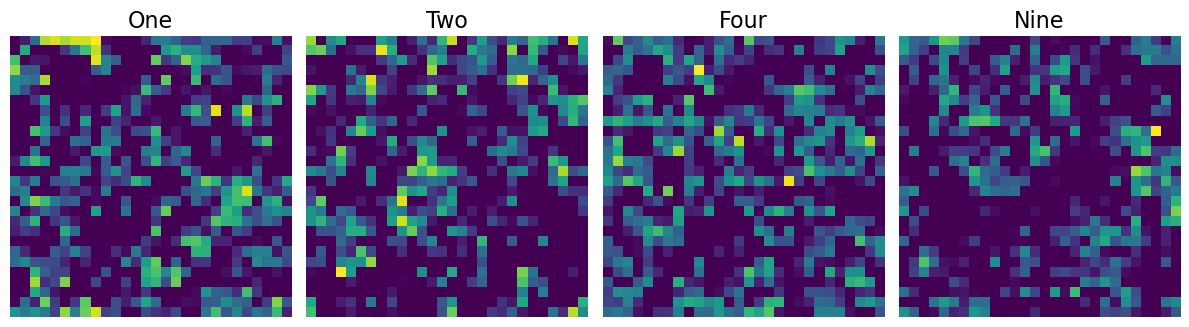

In [174]:
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create the visualization instance.
# All visualization classes accept a model and model-modifier, which, for example,
#     replaces the activation of last layer to linear function so on, in constructor.

image_titles = ['One', 'Two', 'Four', 'Nine']
scores = CategoricalScore([1, 2, 4, 9])

seed_input = tf.random.uniform((4, 28, 28, 1),0,(255*3))/(255*2)

activation_maximization = \
   ActivationMaximization(restored_model,
                          clone=False)

# You can use Score class to specify visualizing target you want.
# And add regularizers or input-modifiers as needed.
activations = \
   activation_maximization(scores,
                           steps=400,
                           seed_input=seed_input,
                           input_modifiers=[Jitter(jitter=1), Rotate2D(degree=0.04)],
                           regularizers=[TotalVariation2D(weight=(0.2)),
                                         Norm(weight=(0.4), p=4)],
                           #optimizer=tf.keras.optimizers.RMSprop(1.0, 0.999),
                           callbacks=[Progress()])

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(activations[i,:,:,0])
    ax[i].axis('off')

    
plt.tight_layout()
plt.show()

In [ ]:
seed_input = tf.random.uniform((4, 28, 28, 1), 254, 255)

activation_maximization = \
   ActivationMaximization(restored_model,
                          clone=False)

# You can use Score class to specify visualizing target you want.
# And add regularizers or input-modifiers as needed.
activations = \
   activation_maximization(scores,
                           steps=500,
                           seed_input=seed_input,
                           input_modifiers=[Jitter(jitter=16), Rotate2D(degree=3)],
                           regularizers=[TotalVariation2D(weight=0.3),
                                         Norm(weight=1, p=1)],
                           optimizer=tf.keras.optimizers.RMSprop(1.0, 0.999),
                           callbacks=[Progress()])

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 3.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 13.9 MB/s eta 0:00:00a 0:00:01


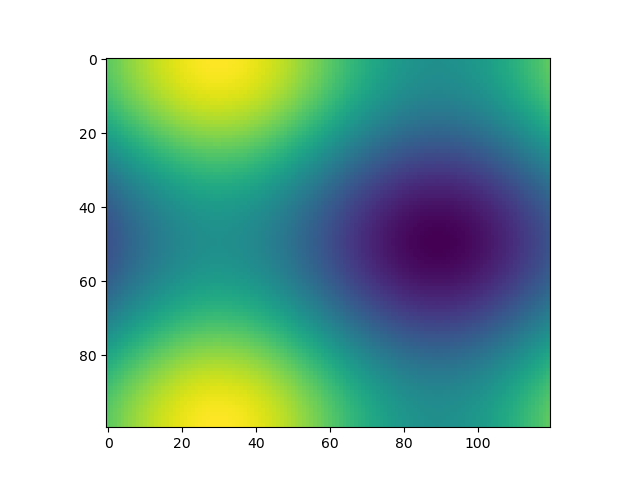

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

fig, ax = plt.subplots()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15
    y += np.pi / 30
    im = ax.imshow(f(x, y), animated=True)
    if i == 0:
        ax.imshow(f(x, y))  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.show()